In [1]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc
from work_in_graph import *

# How to calculate loss ?
# Choices are : 'usual', 'rand_linsim', linsim', 'gaussian_noise', 'usual'.
labels_type = 'usual'

# How many epochs between 2 time-consuming evaluations ?
eval_period = 1

# Wandb
xp_name = 'brouillon'
run_name = f'family train for {labels_type} labels'
print(xp_name,':',run_name)

# Iric
iric_path         = '/home/ebutz/ESL2024/data/full_iric/iric.csv'

# Ontology
ontology_path = '/home/ebutz/ESL2024/data/go-basic.json.gz'

# Set device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Device: '{device}'")

run = wandb.init(project=xp_name, name = run_name)
config = wandb.config
config.labels_type = labels_type
config.val_ratio=0.1
config.homogeneous=False
config.scorelist_size=1000
config.split_ratio=0.8
config.val_ratio=0.1
config.test_ratio=0.1
config.num_neighbors=[70,55,13,89,85]
config.batch_size=1024
config.train_neg_sampling_ratio=224
config.epochs=18
config.disjoint_train_ratio=0.6
config.lr=0.0015308253347932983
config.stopper_metric= 'hit_at_10'
config.stopper_direction="maximize"
config.stopper_patience=5
config.stopper_frequency=1
config.stopper_relative_delta=0.05
config.gamma=1.3
config.alpha=0.42680473078813763
config.gnn_layer='ResGatedGraphConv'
config.dropout=0.1
config.norm='DiffGroupNorm'
config.aggregation = 'min'
config.hidden_channels=115
config.num_layers=3
config.attention_heads=4
config.homogeneous = False
config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

# ------------- Load dataset ------------- #

data = load_iric_data(iric_path, featureless=False)
GO_edge_index = data['go', 'is_a', 'go'].edge_index # Important to extract ontology before making graph undirected
data  = T.ToUndirected(merge=True)(data)            # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data)              # Remove duplicated edges
print(data)
print('data look valid : ',data.validate())

# ------------- Split dataset ------------- #

train_data, val_data, test_data = split_data(data, config)
train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)

# ------------- Loading ontology ------------- #

nxo = from_file(ontology_path)
nxo.freeze()
pwc.nxo = nxo

df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device

# ------------- Model setup ------------- #

gnn_layers = get_gnn_layers(config)
norm_layers = get_norm_layers(config, len(data.node_types))

model = Model(config, data, norm_layers, gnn_layers).to(device)

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


brouillon : family train for usual labels
Device: 'cpu'


wandb: Currently logged in as: butzelliot (esl2024). Use `wandb login --relogin` to force relogin


Graph is homogeneous : False


/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


HeteroData(
  genes={ x=[72335, 29] },
  go={ x=[42979, 3] },
  po={ x=[1662, 2] },
  traito={ x=[1636, 1] },
  prosite_profiles={ x=[627, 1] },
  prosite_patterns={ x=[652, 1] },
  superfamily={ x=[957, 1] },
  panther={ x=[5971, 1] },
  prints={ x=[420, 1] },
  (genes, interacts_with, genes)={ edge_index=[2, 1120849] },
  (genes, gene_ontology, go)={ edge_index=[2, 169248] },
  (genes, trait_ontology, traito)={ edge_index=[2, 15080] },
  (genes, plant_ontology, po)={ edge_index=[2, 6125] },
  (genes, profile, prosite_profiles)={ edge_index=[2, 12239] },
  (genes, pattern, prosite_patterns)={ edge_index=[2, 6677] },
  (genes, family, superfamily)={ edge_index=[2, 20742] },
  (genes, panther_id, panther)={ edge_index=[2, 25319] },
  (genes, prints_id, prints)={ edge_index=[2, 4365] },
  (go, is_a, go)={ edge_index=[2, 136436] },
  (po, is_a, po)={ edge_index=[2, 3548] },
  (traito, is_a, traito)={ edge_index=[2, 3770] },
  (go, rev_gene_ontology, genes)={ edge_index=[2, 169248] },
  (t

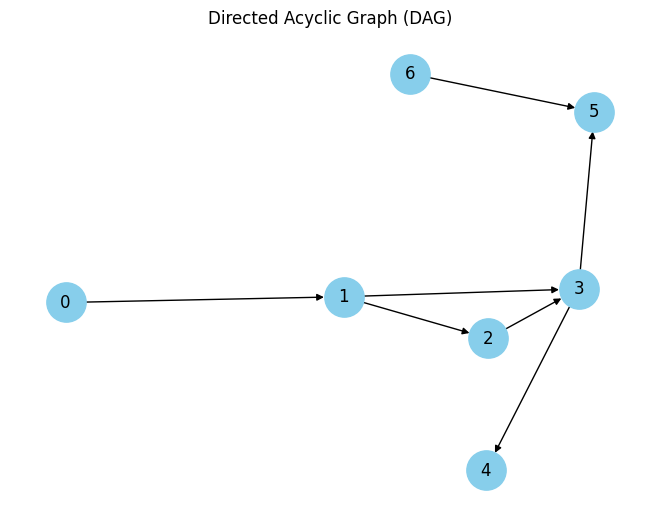

[0, 1, 2, 3, 4, 5, 6]
Distance 2/5


Making dist 2-children  : 100%|██████████| 7/7 [00:00<00:00, 5771.60it/s]


Distance 3/5


Making dist 3-children  : 100%|██████████| 7/7 [00:00<00:00, 5306.37it/s]


Distance 4/5


Making dist 4-children  : 100%|██████████| 7/7 [00:00<00:00, 6286.97it/s]


Distance 5/5


Making dist 5-children  : 100%|██████████| 7/7 [00:00<00:00, 5003.43it/s]


5-family acquired.


Calculating family - lineage : 100%|██████████| 7/7 [00:00<00:00, 4569.67it/s]


,source,1-neighbors,2-neighbors,3-neighbors,4-neighbors,5-neighbors,1-children,2-children,3-children,4-children,5-children,1-parents,2-parents,3-parents,4-parents,5-parents,lineage,family_without_lineage
0,{0},{1},"{0, 2, 3}","{4, 5}",{6},{},{1},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{},{},{},{},"{0, 1, 2, 3, 4, 5}",{6}
1,{1},"{0, 2, 3}","{1, 4, 5}",{6},{},{},"{2, 3}","{3, 4, 5}","{4, 5}",{},{},{0},{},{},{},{},"{0, 1, 2, 3, 4, 5}",{6}
2,{2},"{1, 3}","{0, 2, 4, 5}",{6},{},{},{3},"{4, 5}",{},{},{},{1},{0},{},{},{},"{0, 1, 2, 3, 4, 5}",{6}
3,{3},"{1, 2, 4, 5}","{0, 3, 6}",{},{},{},"{4, 5}",{},{},{},{},"{1, 2}","{0, 1}",{0},{},{},"{0, 1, 2, 3, 4, 5}",{6}
4,{4},{3},"{1, 2, 4, 5}","{0, 6}",{},{},{},{},{},{},{},{3},"{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 4}","{5, 6}"
5,{5},"{3, 6}","{1, 2, 4, 5}",{0},{},{},{},{},{},{},{},"{3, 6}","{1, 2}","{0, 1}",{0},{},"{0, 1, 2, 3, 5, 6}",{4}
6,{6},{5},"{3, 6}","{1, 2, 4}",{0},{},{5},{},{},{},{},{},{},{},{},{},"{5, 6}","{0, 1, 2, 3, 4}"


{0: tensor([6.]), 1: tensor([6.]), 2: tensor([6.]), 3: tensor([6.]), 4: tensor([5., 6.]), 5: tensor([4.]), 6: tensor([0., 1., 2., 3., 4.])}


In [65]:
def plot_graph(edge_index):
    G = nx.DiGraph()
    G.add_edges_from(edge_index.t().tolist())

    pos = nx.spring_layout(G, iterations=50, seed = 1)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, arrows=True)
    plt.title("Directed Acyclic Graph (DAG)")
    plt.show()

def make_source_family_dict(df):
    serie = df.apply(lambda row: torch.Tensor(list(row['family_without_lineage'])), axis = 1)
    return serie.to_dict()

G = nx.DiGraph()
for s, d in zip(GO_edge_index[0].tolist(), GO_edge_index[1].tolist()):
    G.add_edge(s, d)

edge_index = torch.tensor([[0, 1, 1, 2, 3, 3, 6],   # Liste des départs des arêtes
                           [1, 2, 3, 3, 4, 5, 5]],  # Liste des arrivées des arêtes
                          dtype=torch.long)
plot_graph(edge_index)
f = get_family(edge_index, 5)
display(f)
print(make_source_family_dict(f))


In [3]:
# ----------------- Loops ----------------- #
@timer_func
def evaluate(config, loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric=False):
    """
    Evaluate the model on a given data loader.

    Parameters
    ----------
    config : object
        An object containing the configuration parameters for the model.    
    loader : DataLoader
        The data loader to evaluate the model on.
    model : Model
        The model to evaluate.
    criterion : callable
        The loss function to use for evaluation.
    compute_all_metrics : bool, optional
        Whether to compute all metrics or partially. Default is False.
    loader_type : str, optional
        The type of the loader ('validation' or 'test'). Default is 'validation'.
    stopper_metric : str or bool, optional
        The metric that dictates when to stop training. If False, only the loss is computed. Default is False.

    Returns
    -------
    tuple
        A tuple of the evaluation metric and the loss, depending on the value of `stopper_metric`.
        If compute_all_metrics is True, the function logs all metrics to W&B.
    """

    print("Evaluation...")
    model.eval()
    num_neg_samples = loader.neg_sampling.amount
    with torch.no_grad():
        if stopper_metric or compute_all_metrics:
            ground_truths = torch.tensor([], device='cpu')
            preds = torch.tensor([], device='cpu')
            indexes = torch.tensor([], device='cpu')
            total_loss, total_examples = 0, 0
            index_end = loader.batch_size

        for sampled_data in loader:
            sampled_data = sampled_data.to(device)

            batch_size = len(sampled_data[config.labels['tail']].dst_pos_index)
            pred = model(sampled_data, config)
            pos_samples = torch.ones(batch_size, device=device)
            neg_samples = torch.zeros(num_neg_samples*batch_size, device=device)
            ground_truth = torch.cat((pos_samples, neg_samples))

            if stopper_metric or compute_all_metrics: # Store preds and truths for all batches, and compute indices to calc metrics
                index_pos = torch.arange(end=index_end, start=index_end-batch_size) # index for predictions with pos. ground_truth
                index_neg = torch.arange(end=index_end, start=index_end-batch_size).repeat_interleave(num_neg_samples)
                index = torch.cat((index_pos, index_neg))
                indexes = torch.cat((indexes, index.to('cpu')))
                preds = torch.cat((preds, pred.to('cpu')))
                ground_truths = torch.cat((ground_truths, ground_truth.to('cpu')))
                index_end += batch_size

            eval_loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            # if not stopper_metric: # Just logging loss
            #     wandb.log({"running_val_loss": eval_loss})
            #     break
            # else:
            total_loss += float(eval_loss) * pred.numel() 
            total_examples += pred.numel()
            eval_loss = total_loss / total_examples

            # if stopper_metric and not compute_all_metrics:
            #     if index_end >= 2048: # Compute approx. intermediate metric on a few datapoints to speed up hyperopt process
            #         break 


        model.train()

        if stopper_metric and not compute_all_metrics: # Compute only the metric that dictates stopping
            indexes = indexes.long()

            # # Log heatmap between prediction and ground truth. Useful for visualization / debugging. overhead 0.2s per epoch for a single sample.
            # heatmap = heatmaps(preds, ground_truths, indexes) 
            # wandb.log({f"heatmap": wandb.Image(heatmap)})
            # heatmap.close() # Free up memory

            match stopper_metric:
                case "val_loss":
                    eval_loss = total_loss / total_examples
                    return eval_loss
                
                case "mrr":
                    mrr = RetrievalMRR().to(device)
                    return mrr(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_10":
                    hit_at_10 = RetrievalHitRate(top_k=10).to(device)
                    return hit_at_10(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_5":
                    hit_at_5 = RetrievalHitRate(top_k=5).to(device)
                    return hit_at_5(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_3":
                    hit_at_3 = RetrievalHitRate(top_k=3).to(device)
                    return hit_at_3(preds, ground_truths, indexes=indexes), eval_loss
                
                case "hit_at_1":
                    hit_at_1 = RetrievalHitRate(top_k=1).to(device)
                    return hit_at_1(preds, ground_truths, indexes=indexes), eval_loss
                
                case _:
                    raise ValueError(f"Unrecognized stopper metric: '{stopper_metric}'")
                
        if compute_all_metrics: # Compute all metrics at the end of training
            indexes = indexes.long()
            mrr = RetrievalMRR().to(device)
            hit_at_10 = RetrievalHitRate(top_k=10).to(device)
            hit_at_5 = RetrievalHitRate(top_k=5).to(device)
            hit_at_3 = RetrievalHitRate(top_k=3).to(device)
            hit_at_1 = RetrievalHitRate(top_k=1).to(device)
            
            mrr = mrr(preds, ground_truths, indexes=indexes)
            hit_at_10 = hit_at_10(preds, ground_truths, indexes=indexes)
            hit_at_5 = hit_at_5(preds, ground_truths, indexes=indexes)
            hit_at_3 = hit_at_3(preds, ground_truths, indexes=indexes)
            hit_at_1 = hit_at_1(preds, ground_truths, indexes=indexes)

            wandb.log({
                f"{loader_type}MRR": mrr, f"{loader_type}hit_at_10": hit_at_10, f"{loader_type}hit_at_5": hit_at_5, f"{loader_type}hit_at_3": hit_at_3, f"{loader_type}hit_at_1": hit_at_1
            })

    return mrr, eval_loss

@timer_func
def train(config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type = 'usual', eval_period = 0):
    for epoch in range(config.epochs):
        total_loss = total_examples = 0

        for sampled_data in tqdm(train_loader, desc="Training"):

            sampled_data = sampled_data.to(device)
            pred = model(sampled_data, config)
            pos_samples  = torch.ones(len(sampled_data[config.labels['tail']].dst_pos_index), device=device)
            neg_samples  = torch.zeros(len(sampled_data[config.labels['tail']].dst_neg_index.view(-1)), device=device) # As many zeroes as there are negative samples * batch_size
            ground_truth = torch.cat((pos_samples, neg_samples))

            false_tails = sampled_data[config.labels['tail']].dst_neg_index.view(-1)
            true_tails = sampled_data['go']['dst_pos_index']
            true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))


            if labels_type == 'linsim':
                
                lin_neg_samples = pwc.lin_sims_for_batch(true_tails, false_tails)

                pos_samples = pos_samples.to(device)
                lin_neg_samples = lin_neg_samples.to(device)

                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'rand_linsim':

                linsims = pwc.lin_sims_for_batch(true_tails, false_tails)
                lin_neg_samples = pwc.shuffle_tensor(linsims)
                lin_neg_samples.to(device)
                
                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'gaussian_noise':
                # Add gaussian noise to pos_samples to simulate noisy labels. Added noise must be negative and not exceed 1.
                ground_truth += torch.normal(mean=0, std=1, size=(len(ground_truth),), device=device)
                # apply sigmoid
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'usual':
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            wandb.log({"loss": loss})
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        train_loss = total_loss / total_examples
        print(f"Epoch: {epoch:03d}, Avg. Loss: {train_loss:.10f}")


        # scheduler.step()
        if eval_period:
            if epoch%eval_period == 0:
                # Compute metrics and check for early stopping
                score, val_loss = evaluate(config, val_loader, model, criterion, stopper_metric=config.stopper_metric, compute_all_metrics= True)
                wandb.log({"avg_loss": train_loss, "val_loss": val_loss, f"{config.stopper_metric}": score})

        # early_stopper(score)
        # if early_stopper.early_stop:
        #     print("Early stopping triggered at epoch", epoch)
        #     break

    print("Training done.")

    return model

def train_with_family(family_dict, config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type = 'usual', eval_period = 0):
    
    for epoch in range(config.epochs):
        total_loss = total_examples = 0

        for sampled_data in tqdm(train_loader, desc="Training"):

            sampled_data = sampled_data.to(device)

            
            pred = model(sampled_data, config)
            pos_samples  = torch.ones(len(sampled_data[config.labels['tail']].dst_pos_index), device=device)
            neg_samples  = torch.zeros(len(sampled_data[config.labels['tail']].dst_neg_index.view(-1)), device=device) # As many zeroes as there are negative samples * batch_size
            ground_truth = torch.cat((pos_samples, neg_samples))

            false_tails = sampled_data[config.labels['tail']].dst_neg_index.view(-1)
            true_tails = sampled_data['go']['dst_pos_index']
            true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))


            if labels_type == 'linsim':
                
                lin_neg_samples = pwc.lin_sims_for_batch(true_tails, false_tails)

                pos_samples = pos_samples.to(device)
                lin_neg_samples = lin_neg_samples.to(device)

                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'rand_linsim':

                linsims = pwc.lin_sims_for_batch(true_tails, false_tails)
                lin_neg_samples = pwc.shuffle_tensor(linsims)
                lin_neg_samples.to(device)
                
                lin_ground_truth = torch.cat((pos_samples, lin_neg_samples))
                loss = criterion(pred, lin_ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'gaussian_noise':
                # Add gaussian noise to pos_samples to simulate noisy labels. Added noise must be negative and not exceed 1.
                ground_truth += torch.normal(mean=0, std=1, size=(len(ground_truth),), device=device)
                # apply sigmoid
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            if labels_type == 'usual':
                ground_truth = torch.sigmoid(ground_truth)
                loss = criterion(pred, ground_truth, gamma=config.gamma, alpha=config.alpha)

            wandb.log({"loss": loss})
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
        train_loss = total_loss / total_examples
        print(f"Epoch: {epoch:03d}, Avg. Loss: {train_loss:.10f}")


        # scheduler.step()
        if eval_period:
            if epoch%eval_period == 0:
                # Compute metrics and check for early stopping
                score, val_loss = evaluate(config, val_loader, model, criterion, stopper_metric=config.stopper_metric, compute_all_metrics= True)
                wandb.log({"avg_loss": train_loss, "val_loss": val_loss, f"{config.stopper_metric}": score})

        # early_stopper(score)
        # if early_stopper.early_stop:
        #     print("Early stopping triggered at epoch", epoch)
        #     break

    print("Training done.")

In [5]:
dist_families = {}
for d in range(1,6):
    dist_families[d]=get_family(GO_edge_index, max_dist = d)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

Calculating family - lineage : 100%|██████████| 42769/42769 [00:01<00:00, 25432.37it/s] 


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

Making dist 2-children  : 100%|██████████| 42769/42769 [00:00<00:00, 112212.66it/s]


2-family acquired.


Calculating family - lineage : 100%|██████████| 42769/42769 [00:00<00:00, 50263.92it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

Making dist 2-children  : 100%|██████████| 42769/42769 [00:00<00:00, 112437.59it/s]


Distance 3/3


Making dist 3-children  : 100%|██████████| 42769/42769 [00:00<00:00, 122162.56it/s]


3-family acquired.


Calculating family - lineage : 100%|██████████| 42769/42769 [00:01<00:00, 24591.19it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

Making dist 2-children  : 100%|██████████| 42769/42769 [00:00<00:00, 130038.43it/s]


Distance 3/4


Making dist 3-children  : 100%|██████████| 42769/42769 [00:00<00:00, 124023.82it/s]


Distance 4/4


Making dist 4-children  : 100%|██████████| 42769/42769 [00:00<00:00, 121563.36it/s]


4-family acquired.


Calculating family - lineage : 100%|██████████| 42769/42769 [00:04<00:00, 9443.91it/s] 


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,

Making dist 2-children  : 100%|██████████| 42769/42769 [00:00<00:00, 133259.98it/s]


Distance 3/5


Making dist 3-children  : 100%|██████████| 42769/42769 [00:00<00:00, 124063.27it/s]


Distance 4/5


Making dist 4-children  : 100%|██████████| 42769/42769 [00:00<00:00, 122031.25it/s]


Distance 5/5


Making dist 5-children  : 100%|██████████| 42769/42769 [00:00<00:00, 120441.03it/s]


5-family acquired.


Calculating family - lineage : 100%|██████████| 42769/42769 [00:11<00:00, 3883.11it/s]


In [13]:
family_dicts = {}
for key in dist_families.keys():
    family_dicts[key]=make_source_family_dict(dist_families[key])

In [43]:
# L'ensemble des "cousins" du noeud 24512
family_dicts[3][24512]

tensor([24581., 10511., 30480.,  9488.,  3091., 35871.,  3360., 38694., 24873.,
         8236., 14388., 28477., 40254., 32831., 28230.,  2374., 41032.,  2124.,
        20301.,  7252., 13141., 18518., 34905., 32858., 17242., 23900., 11111.,
        18285., 32623.,  6768., 18058., 26512., 13969.,  5009., 15513., 20643.,
        21670.,  7847., 38312., 18856., 32422., 34221., 36796., 31937., 16578.,
        12225., 33223., 28363., 40908., 24527., 17883.,  4573., 27357.,  8159.,
         8674., 10212., 32741., 27367., 35056., 18932., 24310., 18682.])

In [113]:
'''il faut modifier dst_neg_index'''

batchy = next(iter(train_loader))


In [69]:
family_dicts[3]

{0: tensor([12288., 30721., 38914.,  ..., 24570.,  6141., 12287.]),
 1: tensor([10753., 16386., 20484.,  5124.,  4102., 18949., 22024., 24074.,  1554.,
         12306.,  4114., 18451.,  9751., 11288.,  7705., 40474., 35359., 37408.,
         34341., 26667.,  8754., 30770., 34868.,  7733., 38450., 18939.,  7225.,
          4154., 34362., 36412., 15934., 26174., 24639., 12870., 30282., 27215.,
          7762., 15443., 21587., 37462.,  1116.,    92., 42077.,  4191., 18017.,
         18023., 19050., 41068., 14959., 33391., 26225., 33908., 23158., 35961.,
         31866., 16004.,   645., 20613., 36489., 14478., 25748., 23189., 18582.,
         41123., 13989., 40613.,  9382., 29350., 24233., 25773., 22193., 34483.,
         21172., 19636., 17078.,  4790.,  8892.,  5308., 23741.,  4287., 16575.,
          4288.,  8898., 37571., 22732., 23248., 41684., 36566., 30424., 23256.,
         19162., 42720., 35041., 32996., 32488., 16617., 34026.,  5355., 38121.,
         20715., 16621., 29421.,  3829

In [73]:
%%timeit
replace_negatives_with_family_negatives(batchy, family_dicts[3])

44.2 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
liste = [0,1,2]
print(correct_numel(liste, 2))
print(correct_numel(liste, 3))
print(correct_numel(liste, 4))

[1, 0]
[1, 2, 0]
[1, 0, 2, 0]


In [120]:
f3 = family_dicts[3]
df3 = dist_families[3]
df3

,source,1-neighbors,2-neighbors,3-neighbors,1-children,2-children,3-children,1-parents,2-parents,3-parents,lineage,family_without_lineage
0,{0},"{2772, 14807}","{0, 37895, 36876, 26644, 30742, 32792, 31770, ...","{12288, 30721, 38914, 18440, 10248, 40972, 286...",{2772},{22800},{},{14807},{},{},"{22800, 0, 2772, 14807}","{12288, 30721, 38914, 18440, 10248, 36876, 409..."
1,{1},"{41161, 33929, 21078, 27863}","{1, 33057, 30947, 645, 34341, 13989, 1930, 272...","{2560, 10753, 16386, 20484, 5124, 4102, 18949,...",{27863},{30947},{16910},"{41161, 33929, 21078}","{27243, 16173}","{2560, 10464, 19852, 13102}","{2560, 10464, 1, 30947, 33929, 41161, 27243, 1...","{10753, 16386, 20484, 5124, 4102, 18949, 22024..."
2,{2},"{37901, 35950}","{6335, 2, 6202, 36519}","{33986, 30788, 36746, 34974, 14734, 1455, 9232...",{37901},{6202},"{36746, 14734}",{35950},{},{},"{2, 35950, 6202, 37901, 14734, 36746}","{25758, 33986, 30788, 36519, 1455, 9232, 37586..."
3,{3},"{191, 37119, 15967}","{3, 37828, 26629, 17801, 7179, 20301, 19408, 3...","{23042, 18447, 15120, 14609, 3858, 4894, 5919,...","{191, 37119}","{4325, 7847}","{20629, 17046}",{15967},{},{},"{37119, 3, 4325, 20629, 7847, 17046, 15967, 191}","{23042, 26629, 7179, 18447, 15120, 32785, 1460..."
4,{4},"{14453, 15285}","{42276, 4, 12932, 20938, 6570, 37804, 8746, 41...","{28164, 28941, 9230, 28691, 36884, 22291, 6425...","{14453, 15285}","{12932, 19733, 20790}","{12612, 42439, 41561, 32442, 41855, 30527}",{},{},{},"{12932, 12612, 4, 42439, 14453, 15285, 19733, ...","{28164, 28941, 9230, 4112, 28691, 36884, 22291..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42764,{42974},"{18952, 18819, 35101}","{8266, 39690, 28556, 16910, 9431, 1883, 27933,...","{11786, 19981, 17680, 34065, 1810, 16658, 4277...",{35101},{16910},{28270},"{18952, 18819}",{},{},"{18819, 42974, 16910, 18952, 35101, 28270}","{17657, 17403, 39690, 11786, 19981, 17680, 340..."
42765,{42975},"{40400, 7442, 7810}","{3330, 4049, 26898, 1304, 26840, 37914, 17051,...","{13824, 8961, 7041, 31619, 31624, 3082, 40205,...","{40400, 7442, 7810}","{26840, 37914, 14525, 1386, 38047}","{25265, 27458, 15911, 13353, 35371, 18764, 21487}",{},{},{},"{7810, 27458, 15911, 13353, 1386, 35371, 18764...","{13824, 8961, 3330, 3082, 40205, 27150, 18446,..."
42766,{42976},"{13506, 37949, 2922}","{4224, 28546, 19527, 38538, 6669, 18061, 1553,...","{18435, 27147, 34699, 12045, 27531, 12559, 142...",{37949},"{28546, 19445}","{34699, 30947}","{13506, 2922}","{15864, 38538}","{12045, 33310}","{42976, 28546, 30947, 13506, 2922, 34699, 3853...","{18435, 27147, 6669, 12559, 1553, 17436, 18461..."
42767,{42977},"{8785, 29611, 25828, 16134}","{10497, 19972, 37956, 8900, 28614, 23369, 1812...","{35584, 2691, 1927, 16776, 2705, 26262, 11672,...",{29611},{32674},{},"{8785, 25828, 16134}","{22353, 19068, 19972, 24884}",{21301},"{42977, 32674, 25828, 19972, 16134, 29611, 878...","{35584, 10497, 9238, 24088, 23071, 7206, 4145,..."


In [128]:

get_neg_group(pos_id = 1, family_df = df3, default_neg_group = 'family_without_lineage', alt_neg_group = '3-neighbors')

{92,
 255,
 645,
 1116,
 1342,
 1407,
 1554,
 1930,
 2022,
 2497,
 3372,
 3829,
 4102,
 4114,
 4154,
 4191,
 4287,
 4288,
 4790,
 5112,
 5124,
 5308,
 5355,
 6031,
 6071,
 7225,
 7434,
 7518,
 7656,
 7705,
 7733,
 7762,
 7946,
 8754,
 8892,
 8898,
 9084,
 9127,
 9382,
 9469,
 9707,
 9751,
 10065,
 10747,
 10753,
 11026,
 11212,
 11224,
 11288,
 11665,
 12059,
 12142,
 12306,
 12725,
 12773,
 12870,
 13989,
 14478,
 14959,
 15443,
 15618,
 15934,
 16004,
 16331,
 16386,
 16575,
 16617,
 16621,
 17078,
 17778,
 17843,
 18017,
 18023,
 18182,
 18451,
 18582,
 18939,
 18949,
 19050,
 19162,
 19445,
 19636,
 19954,
 20286,
 20300,
 20484,
 20613,
 20715,
 20826,
 20831,
 21172,
 21587,
 21875,
 22024,
 22193,
 22427,
 22732,
 22827,
 23158,
 23189,
 23248,
 23256,
 23298,
 23400,
 23421,
 23439,
 23741,
 24074,
 24233,
 24389,
 24430,
 24639,
 25466,
 25748,
 25773,
 26174,
 26225,
 26667,
 26893,
 26897,
 26943,
 26990,
 27023,
 27215,
 29350,
 29421,
 29971,
 30282,
 30424,
 30692,
 30716

In [131]:
import random

def get_neg_group(pos_id: int, family_df, default_neg_group: str, alt_neg_group: str, min_numel:int = 1):
    neg_group = family_df.iloc[pos_id][default_neg_group]
    if len(neg_group) <= min_numel:
        neg_group = family_df.iloc[pos_id][alt_neg_group]
    return neg_group

def correct_numel(l, num_el):
    random.shuffle(l)
    if len(l) == num_el:
        return l
    elif len(l) > num_el:
        return l[:num_el]  
    elif len(l) < num_el:
        extra_elements = random.choices(l, k = num_el - len(l))
        l = l + extra_elements
    return l


def replace_negatives_with_family_negatives(batch, family_df, default_neg_group: str, alt_neg_group: str):

    # Reading the number of neg per pos in batch :
    numel = batch['go']['dst_neg_index'][0].size()[0]
    # Making a df with batch's pos in a column :
    df = pd.DataFrame(batch['go']['dst_pos_index'].numpy(), columns=['pos'])

    display(df)

    df['family_neg'] = df.apply(lambda row: correct_numel(get_neg_group(row['pos'], family_df, default_neg_group, alt_neg_group)
                                    ,numel)
                                ,axis=1)

    return df

replace_negatives_with_family_negatives(batchy, family_dicts[3], 'family_without_lineage', 'alt_neg_group')


TypeError: replace_negatives_with_family_negatives() missing 2 required positional arguments: 'default_neg_group' and 'alt_neg_group'

In [ ]:
model = Model(config, data, norm_layers, gnn_layers).to(device)
# print(model)

criterion = sigmoid_focal_loss
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
# optimizer = Lion(model.parameters(), lr=config.lr, weight_decay=1e-2)
early_stopper = EarlyStopper(frequency=config.stopper_frequency, patience=config.stopper_patience,
                             direction=config.stopper_direction, relative_delta=config.stopper_relative_delta)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [ ]:
trained_model = train(config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type=config.labels_type, eval_period = eval_period)
evaluate(config,  val_loader, model, criterion, compute_all_metrics=False, loader_type='validation', stopper_metric='hit_at_10')
evaluate(config, test_loader, model, criterion, compute_all_metrics=False, loader_type='test'      , stopper_metric='hit_at_10')

retrained_model = train_with_family(config, train_loader, val_loader, model, criterion, optimizer, early_stopper, labels_type=config.labels_type, eval_period = eval_period, family_dict)

wandb.finish